# 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/abalone-dataset/abalone.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

In [4]:
df = pd.read_csv("/kaggle/input/abalone-dataset/abalone.csv")

In [5]:
print("Loaded dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

Loaded dataset shape: (4177, 9)
Columns: ['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Rings']


In [6]:
RINGS_THRESHOLD = 9  

2. EDA

In [7]:
print(df.info())

print("DESCRIPTIVE STATS (numeric)")
display(df.describe())

print("\nMissing values per column")
display(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB
None
DESCRIPTIVE STATS (numeric)


,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000



Missing values per column


Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

In [8]:
if 'Sex' in df.columns:
    print("\n--- Sex value counts ---")
    display(df['Sex'].value_counts())


--- Sex value counts ---


Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


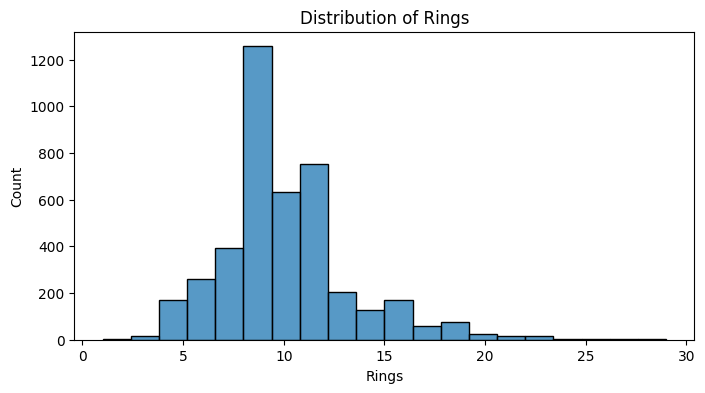

In [ ]:
if 'Rings' in df.columns:
    plt.figure(figsize=(8,4))
    sns.histplot(df['Rings'], bins=20, kde=False)
    plt.title('Distribution of Rings')
    plt.xlabel('Rings')
    plt.show()

#histogram -> how many abalones have each ring count
#right skewed

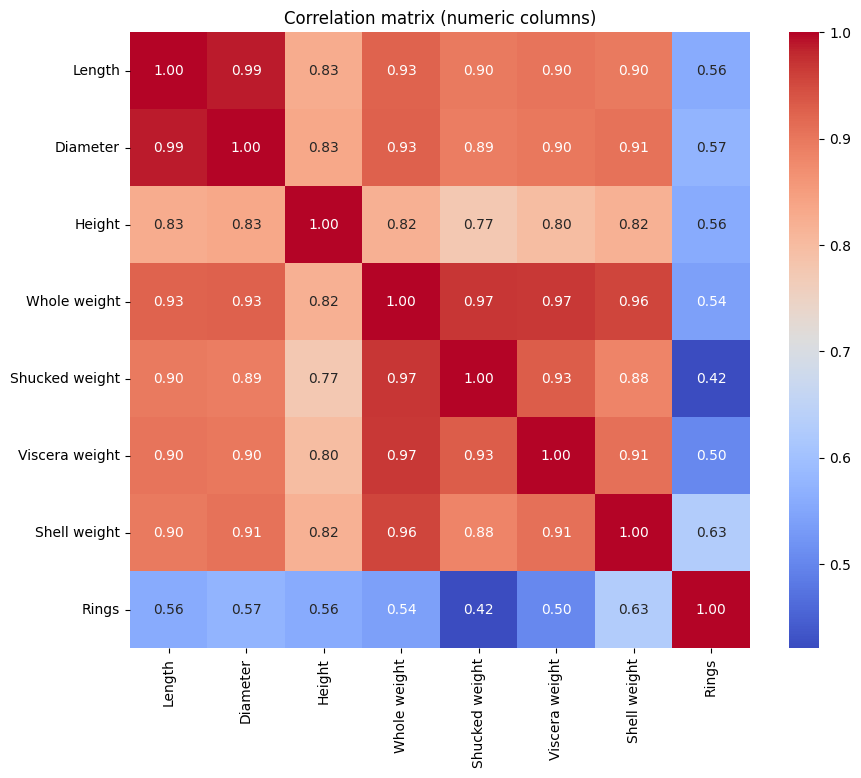

In [10]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) > 1:
    plt.figure(figsize=(10,8))
    sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
    plt.title('Correlation matrix (numeric columns)')
    plt.show()


3. Standardize

In [11]:
if 'Rings' not in df.columns:
    raise ValueError("Expected 'Rings' column in abalone.csv")

df['target'] = (df['Rings'] > RINGS_THRESHOLD).astype(int)  # 1 = old, 0 = young
print("\nTarget distribution (0=young, 1=old):")
display(df['target'].value_counts(normalize=False))


Target distribution (0=young, 1=old):


target
0    2096
1    2081
Name: count, dtype: int64

In [12]:
X = df.drop(columns=['Rings', 'target'])
y = df['target']

In [13]:
if 'Sex' in X.columns:
    X = pd.get_dummies(X, columns=['Sex'], drop_first=True)  # avoid collinear dummies

print("\nFeature columns after encoding:", X.columns.tolist())



Feature columns after encoding: ['Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'Sex_I', 'Sex_M']


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("\nTrain shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (3132, 9) Test shape: (1045, 9)


In [15]:
# Standardize numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Logistic Regression

In [17]:
logreg = LogisticRegression(max_iter=1000, solver='liblinear')  # solver robust for small datasets
logreg.fit(X_train_scaled, y_train)

y_pred = logreg.predict(X_test_scaled)

print("\nLogistic Regression (original features)")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))



Logistic Regression (original features)
Accuracy: 0.7818181818181819

Confusion matrix:
 [[425  99]
 [129 392]]

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.81      0.79       524
           1       0.80      0.75      0.77       521

    accuracy                           0.78      1045
   macro avg       0.78      0.78      0.78      1045
weighted avg       0.78      0.78      0.78      1045



PCA

In [ ]:
pca = PCA()  # fit all components first
pca.fit(X_train_scaled)

explained = pca.explained_variance_ratio_
print("\nPCA explained variance ratio (all components):")
np.set_printoptions(precision=4, suppress=True)
print(explained)

#explained_variance_ratio_ tells how much total variance each principal component holds


PCA explained variance ratio (all components):
[0.7568 0.1263 0.0449 0.0317 0.0185 0.0126 0.0072 0.0014 0.0007]


In [ ]:
cum_explained = np.cumsum(explained)
for i, cum in enumerate(cum_explained):
    if i < 10 or i == len(cum_explained)-1:
        print(f"PC1..PC{i+1} cumulative variance: {cum:.4f}")

# Choose number of components that capture ~95% variance (or choose a fixed number)
n_components = np.searchsorted(cum_explained, 0.95) + 1
print(f"\nRecommended n_components to capture ~95% variance: {n_components}")

#proportion of total variance in the original dataset that is captured
#cumulative vareince helps decide how many PCs to keep

PC1..PC1 cumulative variance: 0.7568
PC1..PC2 cumulative variance: 0.8831
PC1..PC3 cumulative variance: 0.9279
PC1..PC4 cumulative variance: 0.9597
PC1..PC5 cumulative variance: 0.9781
PC1..PC6 cumulative variance: 0.9908
PC1..PC7 cumulative variance: 0.9979
PC1..PC8 cumulative variance: 0.9993
PC1..PC9 cumulative variance: 1.0000

Recommended n_components to capture ~95% variance: 4


In [20]:
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("\nShape after PCA:", X_train_pca.shape)


Shape after PCA: (3132, 4)


Visualize coefficients with a heat map using the Principal components for interpretabilty

In [21]:
logreg_pca = LogisticRegression(max_iter=1000, solver='liblinear')
logreg_pca.fit(X_train_pca, y_train)

# Coeffs per PCA component
coeffs = logreg_pca.coef_.reshape(-1)  # shape: (n_components, ) for binary
pc_names = [f"PC{i+1}" for i in range(n_components)]
coeffs_df = pd.DataFrame(coeffs[np.newaxis, :], index=['logreg_coef'], columns=pc_names)

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


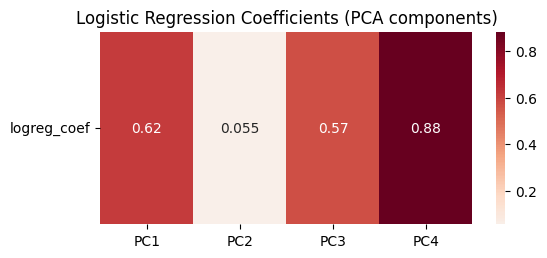

In [ ]:
plt.figure(figsize=(max(6, n_components*0.6), 2.5))
sns.heatmap(coeffs_df, annot=True, cmap='RdBu_r', center=0)
plt.title('Logistic Regression Coefficients (PCA components)')
plt.yticks(rotation=0)
plt.show()
#heatmap of logistic regression coefficients trained on PCA components
#PCA -> uncorrelated linear combinations of your original features

In [23]:
orig_feature_coeffs = np.dot(coeffs, pca.components_)  # result length = n_original_features
orig_coeffs_df = pd.DataFrame(orig_feature_coeffs[np.newaxis, :], index=['proj_coef'], columns=X.columns)


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


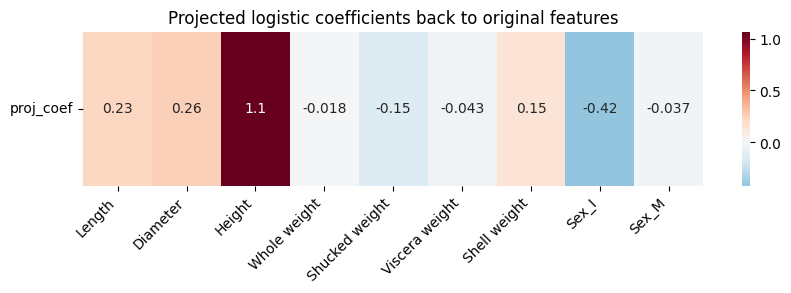

In [24]:
plt.figure(figsize=(10,2))
sns.heatmap(orig_coeffs_df, annot=True, cmap='RdBu_r', center=0)
plt.title('Projected logistic coefficients back to original features')
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.show()

Logistic Regression and SVM using PCA components

In [25]:
y_pred_logreg_pca = logreg_pca.predict(X_test_pca)
print("\nLogistic Regression (PCA features)")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg_pca))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_logreg_pca))
print("\nClassification report:\n", classification_report(y_test, y_pred_logreg_pca))



Logistic Regression (PCA features)
Accuracy: 0.738755980861244

Confusion matrix:
 [[380 144]
 [129 392]]

Classification report:
               precision    recall  f1-score   support

           0       0.75      0.73      0.74       524
           1       0.73      0.75      0.74       521

    accuracy                           0.74      1045
   macro avg       0.74      0.74      0.74      1045
weighted avg       0.74      0.74      0.74      1045



In [26]:
svm_clf = SVC(kernel='rbf', probability=False)
svm_clf.fit(X_train_pca, y_train)
y_pred_svm_pca = svm_clf.predict(X_test_pca)

print("\nSVM (RBF) on PCA features")
print("Accuracy:", accuracy_score(y_test, y_pred_svm_pca))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred_svm_pca))
print("\nClassification report:\n", classification_report(y_test, y_pred_svm_pca))



SVM (RBF) on PCA features
Accuracy: 0.737799043062201

Confusion matrix:
 [[344 180]
 [ 94 427]]

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.66      0.72       524
           1       0.70      0.82      0.76       521

    accuracy                           0.74      1045
   macro avg       0.74      0.74      0.74      1045
weighted avg       0.74      0.74      0.74      1045



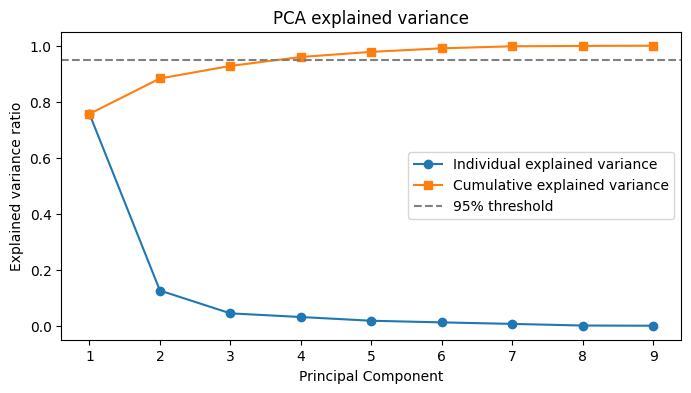

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(1, len(explained)+1), explained, marker='o', label='Individual explained variance')
plt.plot(np.arange(1, len(explained)+1), cum_explained, marker='s', label='Cumulative explained variance')
plt.axhline(0.95, color='gray', linestyle='--', label='95% threshold')
plt.xlabel('Principal Component')
plt.ylabel('Explained variance ratio')
plt.legend()
plt.title('PCA explained variance')
plt.show()

#individual explained vareince -> Variance captured by one principal component
#Cumulative Explained Variance -> Variance captured by a set of principal components combined